## Module 3: Multi-Agent Coordination

##### Project Definition:
* Given a defined task list (including pick and drop locations for N deliveries), operate M Crazyflie agents to complete the defined task as quickly as possible

<img src="./media/world-file.PNG"  width="50%" height="20%">

* Here, number of tasks (N) is 4, and number of Crazyflie agents (M) is 3.
* See image below for a graphical representation of the task list (specific information is provided in the `config.yaml` file)

<img src="./media/robosys-module-3-project.PNG"  width="50%" height="30%">

<br>

##### What to Do:

1. Review and understand task and agent definitions in STEP 1 below

2. Review and understand the *Multi-agent task assignment* implementation in STEP 2 below

3. Implement a *Multi-agent path finding* algorithm (STEP 3 below) that computes a conflict-free paths/trajectory for each agent

4. Integrate your trajectory-following algorithm from Module 2 (STEP 4 below)

<br>




#### STEP 1: Define the task list, agent list and environment parameters

In [1]:
from scripts.utils import Task, Position, State, VelCommand, PosCommand
import yaml
import time

# load configuration file from YAML file
with open('./scripts/config.yaml', 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

use_hardware = config['use_hardware']
agent_init = config['agent_init']
colors = config['agent_colors']
time_delta = config['time_delta']
env = config['map']
num_agents = len(agent_init)
pick_locs = config["pick_loc"]
drop_locs = config["drop_loc"]


print('Starting up the notebook for the Multi-Agent Coordination module... \n')
print(f'Number of Agents: [{num_agents}] -> {[agent_init[i][0] for i in range(len(agent_init))]}')
print(f'Use Hardware: [{use_hardware}]')
print(f'Time Delta (dt): [{time_delta}]')



Starting up the notebook for the Multi-Agent Coordination module... 

Number of Agents: [3] -> ['CF7', 'CF8', 'CF9']
Use Hardware: [False]
Time Delta (dt): [0.25]


##### 1.A. Define Task List

In [2]:
# create the task list
task_list = dict()
pick_locations = config['pick_loc']
drop_locations = config['drop_loc']

print('-----------------------')
print('Task List')
print('-----------------------')

for i in range(len(pick_locations)):
    t = Task(pick_loc=Position(x=pick_locations[i][1][0], y=pick_locations[i][1][1], z=pick_locations[i][1][2]),
             drop_loc=Position(x=drop_locations[i][1][0], y=drop_locations[i][1][1], z=0.0), 
             pick_id=pick_locations[i][0], 
             drop_id=drop_locations[i][0], 
             id='T'+str(i), 
             priority=i)
    task_list[pick_locations[i][0]] = t

    print(f'Task {t.id}: {t.pick_id} -> {t.drop_id}')

print('-----------------------')
    

-----------------------
Task List
-----------------------
Task T0: P1 -> D1
Task T1: P2 -> D2
Task T2: P3 -> D2
Task T3: P4 -> D1
-----------------------


##### 1.B. Define Agent List

In [3]:
# create the agent list

from scripts.Quadrotor import Quadrotor
from scripts.Simulation import Simulation

print('----------------------------------')
print('Agent List (with home position)')
print('----------------------------------')

agent_list = dict()
for i in range(num_agents):
    # define initial state
    start = State(x_pos=agent_init[i][1][0], 
                  y_pos=agent_init[i][1][1])
    # define the appropriate URI
    uri = 'radio://0/'+agent_init[i][0][2:]+'0/2M/E7E7E7E7E7'
    # define agent as Quadrotor
    agent = Quadrotor(init_state=start, 
                      color=colors[i], 
                      id=agent_init[i][0], 
                      uri=uri,
                      take_off_height=agent_init[i][2], 
                      hardware_flag=use_hardware,
                      dt=time_delta)
    agent_list[agent._id] = agent

    if use_hardware:
        print(f'Agent {agent._id}: {agent_list[agent._id].get_pos().x, agent_list[agent._id].get_pos().y} \
              ---> {uri}')
    else:
        print(f'Agent {agent._id}: {agent_list[agent._id].get_pos().x, agent_list[agent._id].get_pos().y} ')


print('----------------------------------')

if use_hardware:
    print('\n !!!!!!!!Please ensure you confirm the Crazyflies are connected to the right radio channels!!!!!!!!')



----------------------------------
Agent List (with home position)
----------------------------------
Agent CF7: (-0.6, 0.9) 
Agent CF8: (-0.6, 0.3) 
Agent CF9: (-0.6, -0.3) 
----------------------------------


#### STEP 2: Implement Multi-Agent Task Assignment

##### 2.A. Define the Ground Constrol System & compute assignment

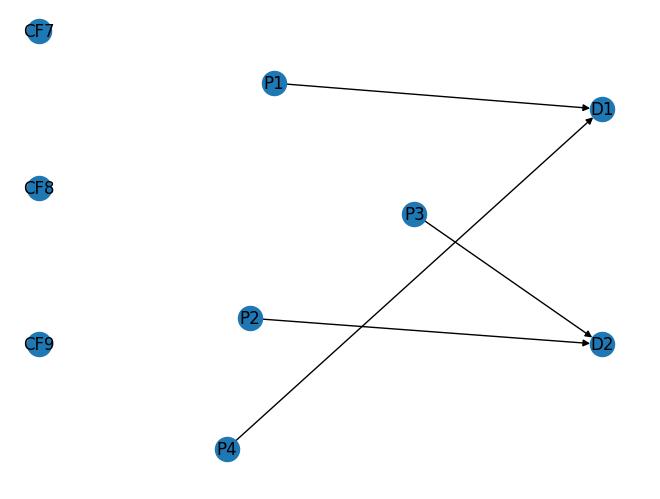

In [4]:
from scripts.GroundControl import GroundControlSystem

# instantiate ground control system object
gcs = GroundControlSystem(agent_list=agent_list, 
                          task_list=task_list,
                          env=env)

# creates a directed graph based on the agents and task list
gcs.set_task_graph(draw=True) # toggle draw True or False


----------------------
Task Assignment
----------------------
Agent CF9 : P4 -> D1
Agent CF7 : P1 -> D1
Agent CF8 : P2 -> D2
Agent CF8 : P3 -> D2
----------------------


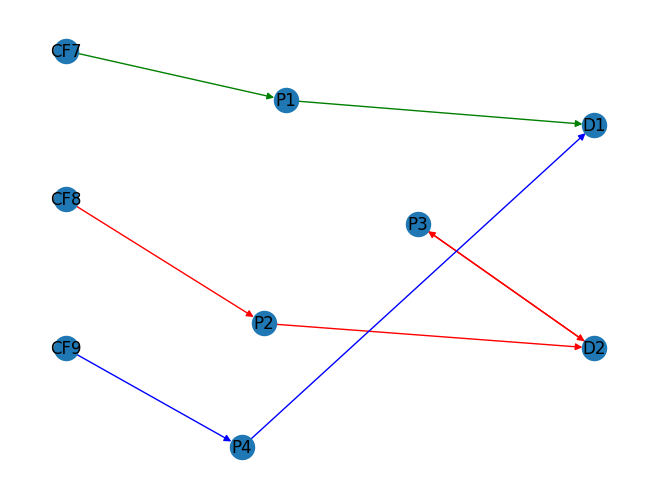

In [5]:

print('----------------------')
print('Task Assignment')
print('----------------------')

# create task assignment
gcs.create_task_assignment()

print('----------------------')


# observe task assignment
task_assignment = gcs.get_task_assignment(draw=True)


#### STEP 3: Implement Multi-Agent Path Finding

In [6]:
# 2D plot of the scene
import plotly.graph_objects as go
fig1 = go.Figure()
fig2 = go.Figure()

sim = Simulation(env=env, fig1=fig1, fig2=fig2)

sim.add_agents(agent_list)
sim.set_task_list(task_list)
sim.init_plot()


##### 3.A. Compute collision-free paths

[(-0.6, 0.9), (0.4, 0.7), (1.8, 0.6)]
[[-0.6, 0.9, 0.05, 0], [-0.5, 0.8, 0.05, 0], [-0.4, 0.7, 0.05, 0], [-0.3, 0.7, 0.05, 0], [-0.2, 0.7, 0.05, 0], [-0.1, 0.7, 0.05, 0], [0.0, 0.7, 0.05, 0], [0.1, 0.7, 0.05, 0], [0.2, 0.7, 0.05, 0], [0.3, 0.7, 0.05, 0], [0.4, 0.7, 0.05, 0], [0.4, 0.7, 0.05, 0], [0.5, 0.7, 0.05, 0], [0.6, 0.7, 0.05, 0], [0.7, 0.7, 0.05, 0], [0.8, 0.7, 0.05, 0], [0.9, 0.7, 0.05, 0], [1.0, 0.7, 0.05, 0], [1.1, 0.7, 0.05, 0], [1.2, 0.7, 0.05, 0], [1.3, 0.6, 0.05, 0], [1.4, 0.6, 0.05, 0], [1.5, 0.6, 0.05, 0], [1.6, 0.6, 0.05, 0], [1.7, 0.6, 0.05, 0], [1.8, 0.6, 0.05, 0]]


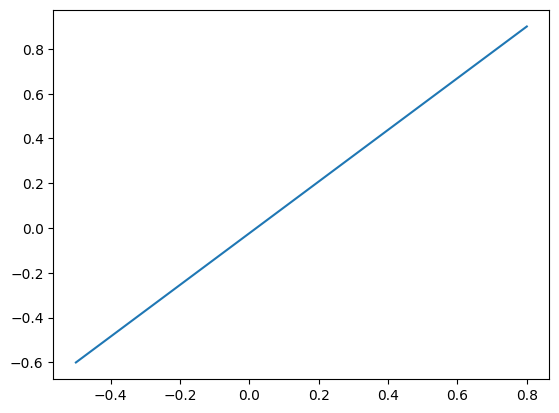

[(-0.6, 0.3), (0.3, -0.2), (1.8, -0.3), (1.0, 0.2), (1.8, -0.3)]
[[-0.6, 0.3, 0.15, 0], [-0.5, 0.2, 0.15, 0], [-0.4, 0.1, 0.15, 0], [-0.3, 0.0, 0.15, 0], [-0.2, -0.1, 0.15, 0], [-0.1, -0.2, 0.15, 0], [0.0, -0.2, 0.15, 0], [0.1, -0.2, 0.15, 0], [0.2, -0.2, 0.15, 0], [0.3, -0.2, 0.15, 0], [0.3, -0.2, 0.15, 0], [0.4, -0.2, 0.15, 0], [0.5, -0.2, 0.15, 0], [0.6, -0.2, 0.15, 0], [0.7, -0.2, 0.15, 0], [0.8, -0.2, 0.15, 0], [0.9, -0.2, 0.15, 0], [1.0, -0.2, 0.15, 0], [1.1, -0.2, 0.15, 0], [1.2, -0.2, 0.15, 0], [1.3, -0.3, 0.15, 0], [1.4, -0.3, 0.15, 0], [1.5, -0.3, 0.15, 0], [1.6, -0.3, 0.15, 0], [1.7, -0.3, 0.15, 0], [1.8, -0.3, 0.15, 0], [1.8, -0.3, 0.15, 0], [1.7, -0.2, 0.15, 0], [1.6, -0.1, 0.15, 0], [1.5, 0.0, 0.15, 0], [1.4, 0.1, 0.15, 0], [1.3, 0.2, 0.15, 0], [1.2, 0.2, 0.15, 0], [1.1, 0.2, 0.15, 0], [1.0, 0.2, 0.15, 0], [1.0, 0.2, 0.15, 0], [1.1, 0.1, 0.15, 0], [1.2, 0.0, 0.15, 0], [1.3, -0.1, 0.15, 0], [1.4, -0.2, 0.15, 0], [1.5, -0.3, 0.15, 0], [1.6, -0.3, 0.15, 0], [1.7, -0.3, 0.15,

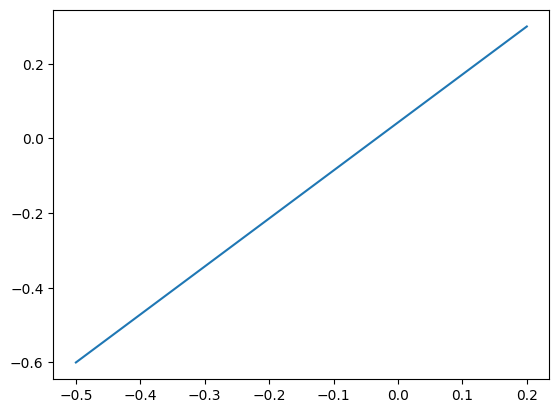

[(-0.6, -0.3), (0.2, -0.7), (1.8, 0.6)]
[[-0.6, -0.3, 0.25, 0], [-0.5, -0.4, 0.25, 0], [-0.4, -0.5, 0.25, 0], [-0.3, -0.6, 0.25, 0], [-0.2, -0.7, 0.25, 0], [-0.1, -0.7, 0.25, 0], [0.0, -0.7, 0.25, 0], [0.1, -0.7, 0.25, 0], [0.2, -0.7, 0.25, 0], [0.2, -0.7, 0.25, 0], [0.3, -0.7, 0.25, 0], [0.4, -0.7, 0.25, 0], [0.5, -0.7, 0.25, 0], [0.6, -0.7, 0.25, 0], [0.7, -0.7, 0.25, 0], [0.8, -0.7, 0.25, 0], [0.9, -0.7, 0.25, 0], [1.0, -0.7, 0.25, 0], [1.1, -0.7, 0.25, 0], [1.2, -0.7, 0.25, 0], [1.3, -0.6, 0.25, 0], [1.4, -0.5, 0.25, 0], [1.5, -0.4, 0.25, 0], [1.6, -0.3, 0.25, 0], [1.7, -0.2, 0.25, 0], [1.8, -0.1, 0.25, 0], [1.8, 0.0, 0.25, 0], [1.8, 0.1, 0.25, 0], [1.8, 0.2, 0.25, 0], [1.8, 0.3, 0.25, 0], [1.8, 0.4, 0.25, 0], [1.8, 0.5, 0.25, 0], [1.8, 0.6, 0.25, 0]]


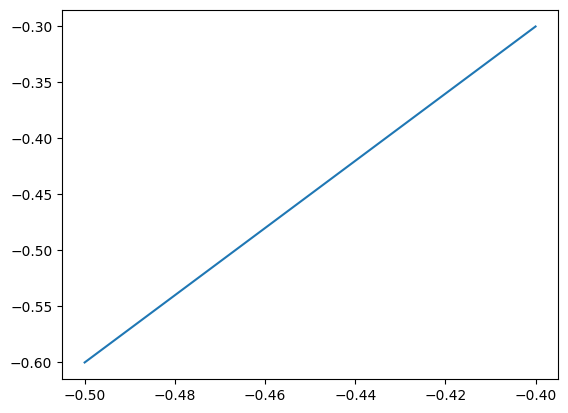

In [28]:
# Here, you should implement your multi-agent path finding algorithm...
gcs.generate_agent_paths()

from generate_map import base_map, agent_map
from transform import transform_path
from single_agent_astar import astar

import matplotlib.pyplot as plt

hover_height=0.05
for agent_instance in agent_list:
    #Create list of tuples that the agent wants to visit
    agent_pois=[]
    #Find the starting position of the agent
    start_pos=(agent_list[agent_instance].get_pos().x,agent_list[agent_instance].get_pos().y)
    #The first point of intrest is the starting position
    agent_pois.append(start_pos)

    #Finds the list of tasks for this agent
    agent_task_list=task_assignment[agent_list[agent_instance]]
    #If there is more than one task, the tasks will be a list and will be added sequentially
    if type(agent_task_list) is list:
        for task in agent_task_list:
            pick_loc=(task.pick_loc.x,task.pick_loc.y)
            agent_pois.append(pick_loc)
            drop_loc=(task.drop_loc.x,task.drop_loc.y)
            agent_pois.append(drop_loc)
    #If there is only a single task, the pick and drop locations are added directly
    else:
        pick_loc=(agent_task_list.pick_loc.x,agent_task_list.pick_loc.y)
        agent_pois.append(pick_loc)
        drop_loc=(agent_task_list.drop_loc.x,agent_task_list.drop_loc.y)
        agent_pois.append(drop_loc)
    print(agent_pois)

    # making the path
    gen_map = base_map(env, pick_locs, drop_locs)
    ag_map = agent_map(gen_map, agent_pois)

    ag_path = []
    for i in range(len(agent_pois) - 1):
        x1 = int(agent_pois[i][0] * 10 + 9)
        x2 = int(agent_pois[i+1][0] * 10 + 9)
        y1 = int(agent_pois[i][1] * 10 + 9)
        y2 = int(agent_pois[i+1][1] * 10 + 9)
        ag_path += astar((y1, x1), (y2, x2), ag_map)
    
    path_2D = transform_path(ag_path)

    path_3D = []
    for point in path_2D:
        path_3D.append([point[1], point[0], hover_height, 0])

    agent_list[agent_instance]._trajectory = path_3D

    print(agent_list[agent_instance]._trajectory)

    hover_height += .1
    hover_height = round(hover_height, 2)

    plt.plot(path_2D[1], path_2D[0])
    plt.show()



# -----------------------------
# Plotter
# sim.init_plot()

### Main Control Loop

#### STEP 4: Implement the Path planning & collision avoidance algorithm

In [26]:
# Upload your functions from Module 2 here
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

def get_pose(scf):
    log_pos = LogConfig(name='Position', period_in_ms=200)
    log_pos.add_variable('kalman.stateX', 'float')
    log_pos.add_variable('kalman.stateY', 'float')
    log_pos.add_variable('kalman.stateZ', 'float')
    scf.cf.log.add_config(log_pos)

    with SyncLogger(scf, log_pos) as logger:
            for log_entry in logger:
                data = log_entry[1]
                x = data['kalman.stateX']
                y = data['kalman.stateY']
                z = data['kalman.stateZ']
                return x, y, z


def agent_nav(agent, point):
    print(point)
    P = PosCommand()
    P.x = point[0]
    P.y = point[1]
    P.z = point[2]
    P.psi = point[3]
    
    if agent._hardware_flag:
        agent.position_setpoint_hw(P)
    else:
        agent.position_setpoint_sim(P)
        


##### STEP 5: Run the Main control loop

##### 5.A. Run a hardware test [If using hardware]

In [9]:
# for agent in agent_list.values():
#     agent.initialize_agent()


# time.sleep(3)


# for agent in agent_list.values():
#     agent.land()


##### 5.B. Run main loop

In [27]:
time_lapse = 0
flight_duration = 3

# initialize and take off all agents
for agent in agent_list.values():
    agent.initialize_agent()

time.sleep(3)

# while True:
while time_lapse < flight_duration: #secs
    step = 0
    for agent in agent_list.values():
        trajectory=agent.get_trajectory()
        agent.control_method = agent_nav(agent,trajectory[step])
        
        # print out current position of each agent
        x, y, z = agent.get_pos().x, agent.get_pos().y, agent.get_pos().z
        print(f'Agent [{agent._id}]: t = {time_lapse} -> [x, y, z] = [{x:0.3f}, {y:0.3f}, {z:0.3f}]')
        
    print('------------------------------------')    
    step += 1
    # keep track of time lapsed
    time_lapse += time_delta

    time.sleep(time_delta) 

# land all agents
for agent in agent_list.values():
    agent.land()

# plot the agent trajectory
sim.update_plot()


Agent [CF7] is Taking Off!!
Agent [CF8] is Taking Off!!
Agent [CF9] is Taking Off!!
[-0.6, 0.9, 0.05, 0]
Agent [CF7]: t = 0 -> [x, y, z] = [-0.600, 0.900, 0.050]
[-0.6, 0.3, 0.15, 0]
Agent [CF8]: t = 0 -> [x, y, z] = [-0.600, 0.300, 0.150]
[-0.6, -0.3, 0.25, 0]
Agent [CF9]: t = 0 -> [x, y, z] = [-0.600, -0.300, 0.250]
------------------------------------
[-0.6, 0.9, 0.05, 0]
Agent [CF7]: t = 0.25 -> [x, y, z] = [-0.600, 0.900, 0.050]
[-0.6, 0.3, 0.15, 0]
Agent [CF8]: t = 0.25 -> [x, y, z] = [-0.600, 0.300, 0.150]
[-0.6, -0.3, 0.25, 0]
Agent [CF9]: t = 0.25 -> [x, y, z] = [-0.600, -0.300, 0.250]
------------------------------------
[-0.6, 0.9, 0.05, 0]
Agent [CF7]: t = 0.5 -> [x, y, z] = [-0.600, 0.900, 0.050]
[-0.6, 0.3, 0.15, 0]
Agent [CF8]: t = 0.5 -> [x, y, z] = [-0.600, 0.300, 0.150]
[-0.6, -0.3, 0.25, 0]
Agent [CF9]: t = 0.5 -> [x, y, z] = [-0.600, -0.300, 0.250]
------------------------------------
[-0.6, 0.9, 0.05, 0]
Agent [CF7]: t = 0.75 -> [x, y, z] = [-0.600, 0.900, 0.050]
[